# Income Prediction Model - Complete Analysis

This notebook demonstrates our **custom Logistic Regression implementation** with mathematical transparency.

## Dataset Overview

**Source:** Adult Income Dataset (Census Bureau)

**Problem:** Predict whether a person earns >$50K/year based on demographic and work-related features

**Dataset Statistics:**
- **Total samples:** 26,048 (after train/val split from original 32,561)
- **Training set:** 20,838 samples (80%)
- **Validation set:** 5,210 samples (20%)

**Class Distribution:**
- **≤$50K:** ~75% (majority class - imbalanced)
- **>$50K:** ~25% (minority class)

**Features (13 total):**
- **Numeric (5):** age, educational-num, capital-gain, capital-loss, hours-per-week
- **Categorical (8):** workclass, education, marital-status, occupation, relationship, race, gender, native-country

**Target Variable:** `income_>50K` (binary: 0 = ≤50K, 1 = >50K)

**Challenge:** Class imbalance makes this problem harder - the model could achieve 75% accuracy by always predicting ≤50K!

In [13]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import load_model

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


## 1. Load Pre-Split Data and Model

We use pre-split data to ensure reproducibility and fair evaluation.

In [14]:
# Load the pre-split data
train_df = pd.read_csv('../data/train_split.csv')
val_df = pd.read_csv('../data/val_split.csv')

X_train = train_df.drop(columns=["income_>50K"])
y_train = train_df["income_>50K"]

X_val = val_df.drop(columns=["income_>50K"])
y_val = val_df["income_>50K"]

# Load trained model
model = load_model()

# Make predictions
preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

X_val_processed = preprocessor.transform(X_val)
y_pred = logreg.predict(X_val_processed)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print("✓ Data and model loaded successfully!")

Training samples: 35165
Validation samples: 8792
✓ Data and model loaded successfully!


## 2. Custom Logistic Regression - Training Curve

Our implementation uses gradient descent. Let's visualize the learning process.

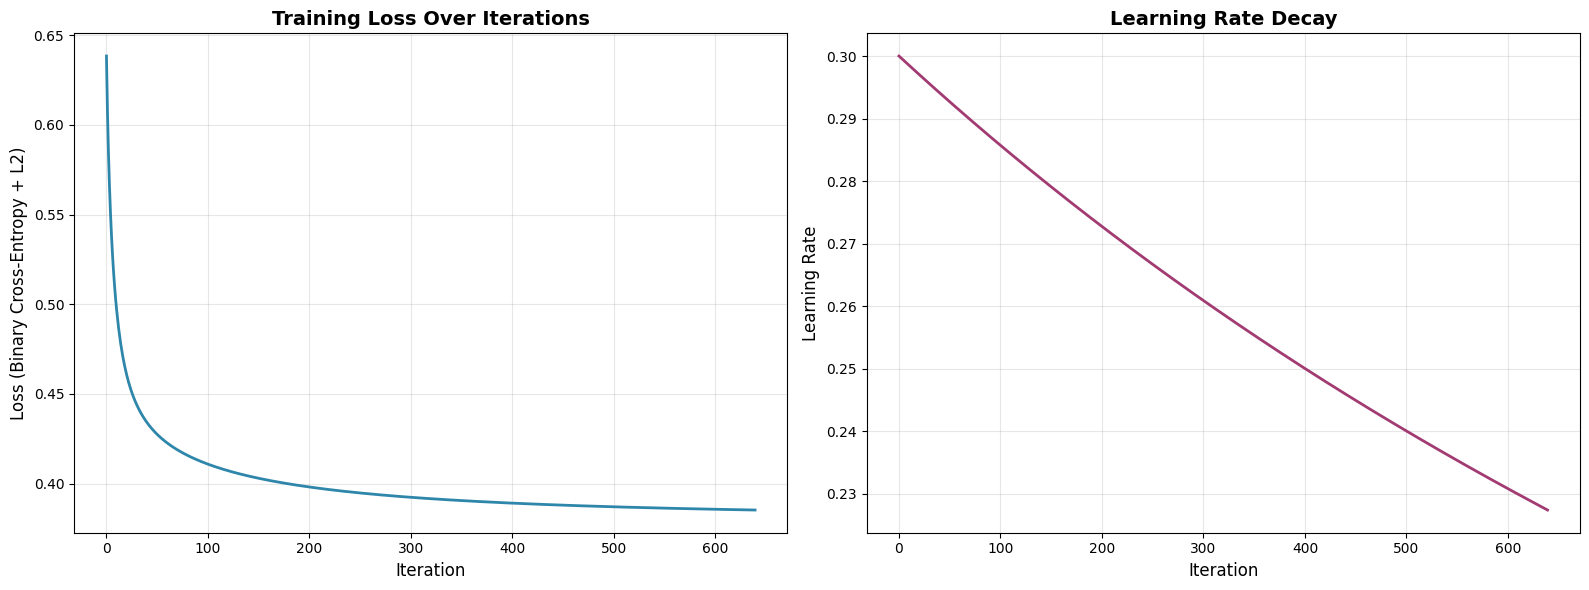

Initial loss: 0.6384
Final loss: 0.3853
Total iterations: 640
Loss reduction: 39.65%


In [15]:
# Plot training loss curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss curve
ax1.plot(logreg.losses, linewidth=2, color='#2E86AB')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Loss (Binary Cross-Entropy + L2)', fontsize=12)
ax1.set_title('Training Loss Over Iterations', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Learning rate decay curve (if available)
if hasattr(logreg, 'initial_lr') and hasattr(logreg, 'lr_decay'):
    iterations = range(len(logreg.losses))
    learning_rates = [logreg.initial_lr / (1 + logreg.lr_decay * i) for i in iterations]
    ax2.plot(learning_rates, linewidth=2, color='#A23B72')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title('Learning Rate Decay', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
else:
    # Model was trained with old version - show info message
    ax2.text(0.5, 0.5, 'Learning rate decay not available\n(retrain model to see this plot)', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Learning Rate Decay', fontsize=14, fontweight='bold')
    ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Initial loss: {logreg.losses[0]:.4f}")
print(f"Final loss: {logreg.losses[-1]:.4f}")
print(f"Total iterations: {len(logreg.losses)}")
print(f"Loss reduction: {((logreg.losses[0] - logreg.losses[-1]) / logreg.losses[0] * 100):.2f}%")

# Check if model needs retraining
if not hasattr(logreg, 'initial_lr'):
    print("\n⚠️  Model was trained with old version. Retrain to see improvements:")
    print("   cd ../src && python train_model.py")

## 3. Model Performance Metrics

In [16]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1 Score": f1_score(y_val, y_pred)
}

# Display metrics
print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
for metric, value in metrics.items():
    print(f"{metric:12s}: {value:.4f}")
print("="*50)

# Create metrics dataframe for visualization
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])
metrics_df

MODEL PERFORMANCE METRICS
Accuracy    : 0.8363
Precision   : 0.6363
Recall      : 0.7376
F1 Score    : 0.6832


,Metric,Score
0,Accuracy,0.836328
1,Precision,0.636326
2,Recall,0.737643
3,F1 Score,0.683249


## 4. Confusion Matrix

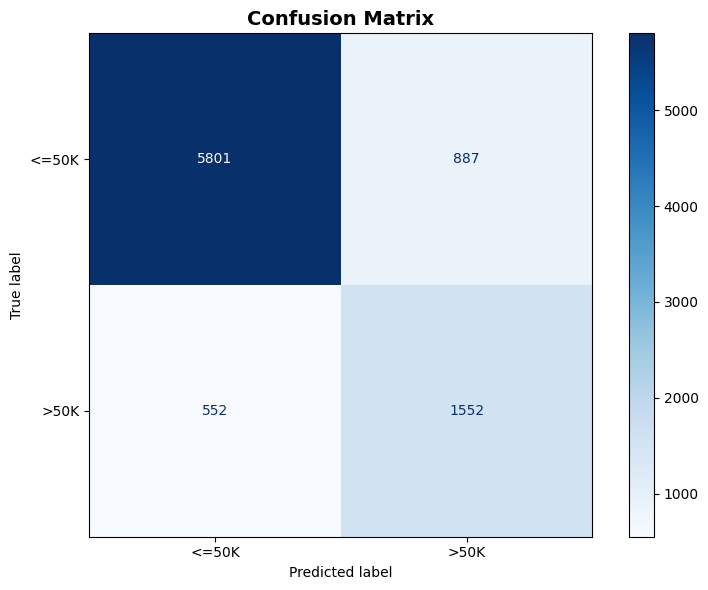


True Negatives:   5801
False Positives:   887
False Negatives:   552
True Positives:   1552


In [17]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives:  {cm[0][0]:5d}")
print(f"False Positives: {cm[0][1]:5d}")
print(f"False Negatives: {cm[1][0]:5d}")
print(f"True Positives:  {cm[1][1]:5d}")

## 5. Classification Report

In [18]:
print(classification_report(y_val, y_pred, target_names=['<=50K', '>50K']))

              precision    recall  f1-score   support

       <=50K       0.91      0.87      0.89      6688
        >50K       0.64      0.74      0.68      2104

    accuracy                           0.84      8792
   macro avg       0.77      0.80      0.79      8792
weighted avg       0.85      0.84      0.84      8792



## 6. Metrics Visualization

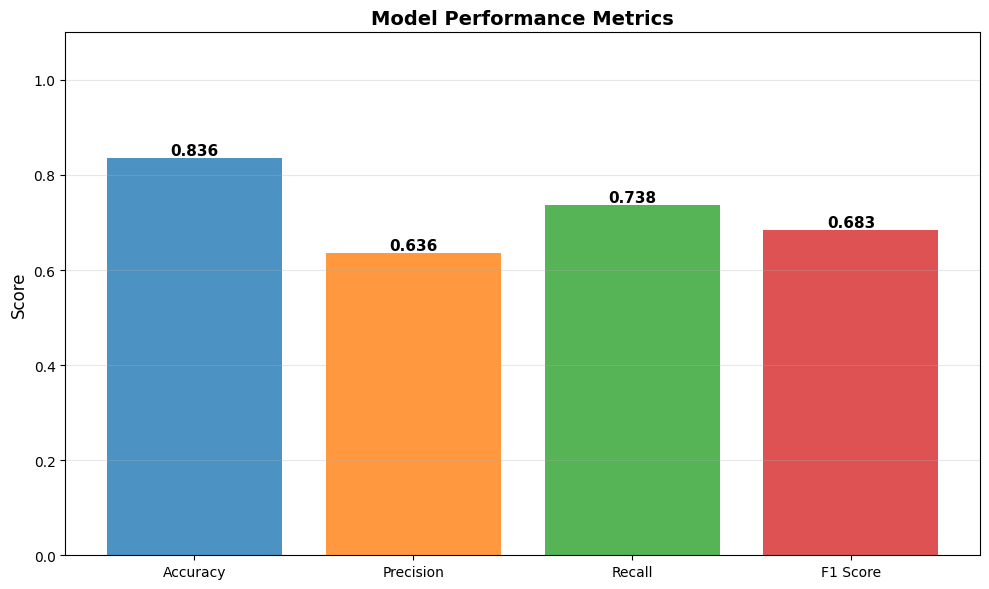

In [19]:
# Bar plot of metrics
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

bars = ax.bar(metric_names, metric_values, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
              alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.3f}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Feature Importance (Weights Analysis)

In logistic regression, the weights represent feature importance.
- **Positive weights** → increase probability of >50K income
- **Negative weights** → decrease probability of >50K income

In [20]:
# Extract feature weights from our custom model
preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

# Get feature names
feature_names = []

# Numeric features
numeric_features = preprocessor.transformers_[0][2]
feature_names.extend(numeric_features)

# Categorical features (one-hot encoded)
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
feature_names.extend(cat_feature_names)

# Get weights (flatten from column vector)
weights = logreg.weights.flatten()

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
})

importance_df = importance_df.sort_values('Abs_Weight', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
                          Feature    Weight  Abs_Weight
                     capital-gain  1.852820    1.852820
marital-status_Married-civ-spouse  1.119896    1.119896
                relationship_Wife  0.902576    0.902576
     marital-status_Never-married -0.803238    0.803238
           relationship_Own-child -0.800409    0.800409
                  educational-num  0.691092    0.691092
       occupation_Exec-managerial  0.632704    0.632704
         occupation_Other-service -0.577609    0.577609
           relationship_Unmarried -0.528052    0.528052
                    gender_Female -0.474869    0.474869
       workclass_Self-emp-not-inc -0.440953    0.440953
        occupation_Prof-specialty  0.414851    0.414851
                   hours-per-week  0.398436    0.398436
                              age  0.396448    0.396448
          marital-status_Divorced -0.368548    0.368548
                    workclass_nan -0.355774    0.355774
      relationsh

## 8. Feature Weight Visualization

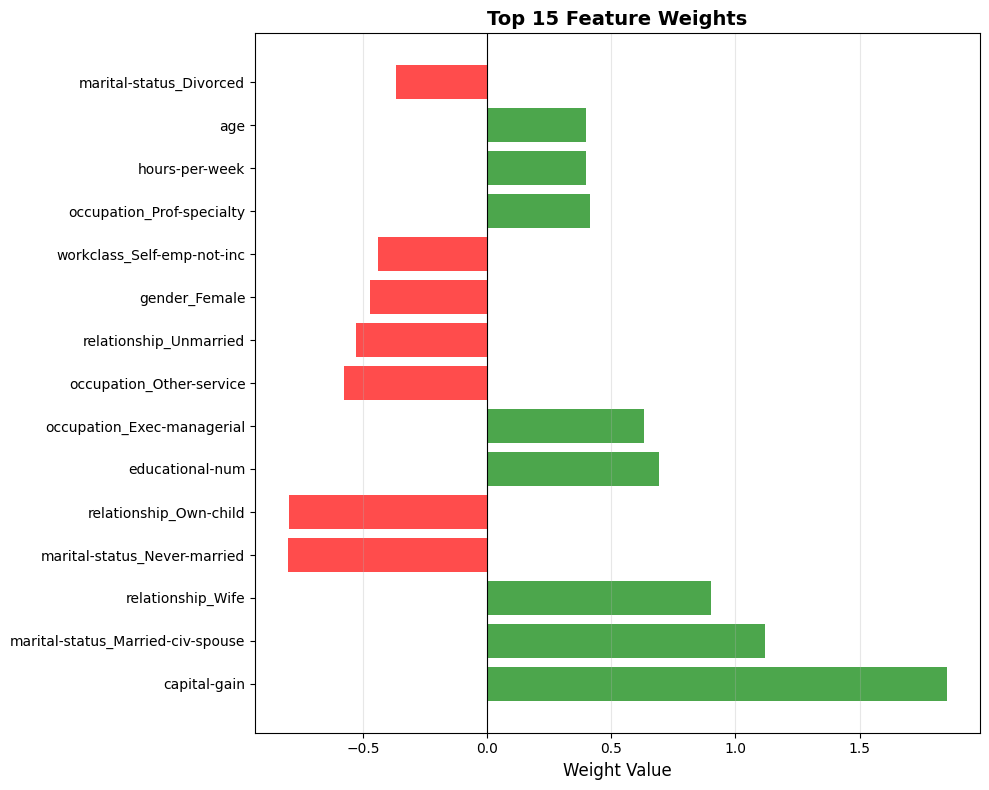

In [21]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_features['Weight']]

ax.barh(range(len(top_features)), top_features['Weight'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Weight Value', fontsize=12)
ax.set_title(f'Top {top_n} Feature Weights', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Sigmoid Function Visualization

The sigmoid function σ(z) = 1/(1 + e^(-z)) transforms linear predictions into probabilities.
Let's visualize both the mathematical function and how our model's predictions are distributed.

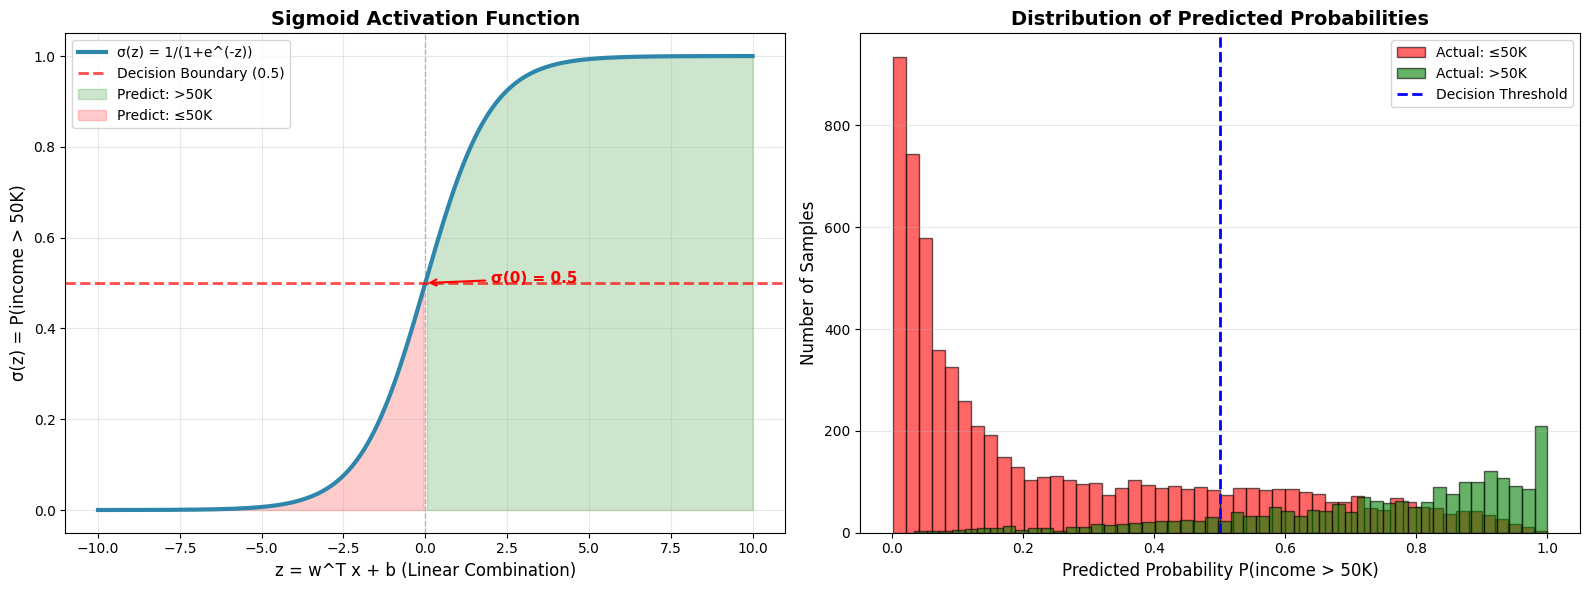

PREDICTION PROBABILITY STATISTICS

For actual ≤50K samples:
  Mean probability: 0.2544
  Median probability: 0.1338
  Std deviation: 0.2623

For actual >50K samples:
  Mean probability: 0.7422
  Median probability: 0.8025
  Std deviation: 0.2196

Separation quality:
  Difference in means: 0.4878


In [22]:
import matplotlib.pyplot as plt

# Create visualization with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT PLOT: Sigmoid Function ---
z_range = np.linspace(-10, 10, 200)
sigmoid_values = logreg.sigmoid(z_range)

ax1.plot(z_range, sigmoid_values, linewidth=3, color='#2E86AB', label='σ(z) = 1/(1+e^(-z))')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Decision Boundary (0.5)')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values >= 0.5), 
                  alpha=0.2, color='green', label='Predict: >50K')
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values < 0.5), 
                  alpha=0.2, color='red', label='Predict: ≤50K')

ax1.set_xlabel('z = w^T x + b (Linear Combination)', fontsize=12)
ax1.set_ylabel('σ(z) = P(income > 50K)', fontsize=12)
ax1.set_title('Sigmoid Activation Function', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_ylim([-0.05, 1.05])

# Add annotation
ax1.annotate('σ(0) = 0.5', xy=(0, 0.5), xytext=(2, 0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=11, color='red', fontweight='bold')

# --- RIGHT PLOT: Model Predictions Distribution ---
y_proba = logreg.predict_proba(X_val_processed)[:, 1]

# Separate by actual class
proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]

ax2.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Actual: ≤50K', edgecolor='black')
ax2.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Actual: >50K', edgecolor='black')
ax2.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Decision Threshold')

ax2.set_xlabel('Predicted Probability P(income > 50K)', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("="*60)
print("PREDICTION PROBABILITY STATISTICS")
print("="*60)
print(f"\nFor actual ≤50K samples:")
print(f"  Mean probability: {proba_class0.mean():.4f}")
print(f"  Median probability: {np.median(proba_class0):.4f}")
print(f"  Std deviation: {proba_class0.std():.4f}")

print(f"\nFor actual >50K samples:")
print(f"  Mean probability: {proba_class1.mean():.4f}")
print(f"  Median probability: {np.median(proba_class1):.4f}")
print(f"  Std deviation: {proba_class1.std():.4f}")

print(f"\nSeparation quality:")
print(f"  Difference in means: {abs(proba_class1.mean() - proba_class0.mean()):.4f}")
print("="*60)

## 10. Interpretation

- **Green bars**: Features that increase P(income > 50K)
- **Red bars**: Features that decrease P(income > 50K)
- Weight magnitude indicates feature importance

## 10. Threshold Optimization

The default threshold of 0.5 may not be optimal for imbalanced datasets.
Let's find the best threshold to maximize F1 score.

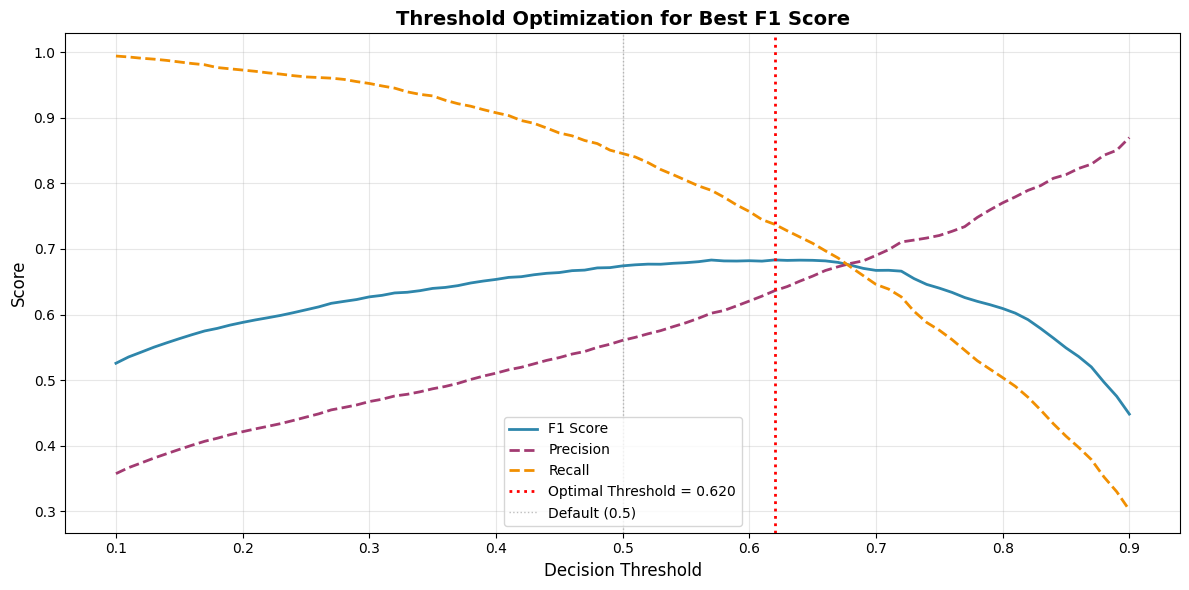

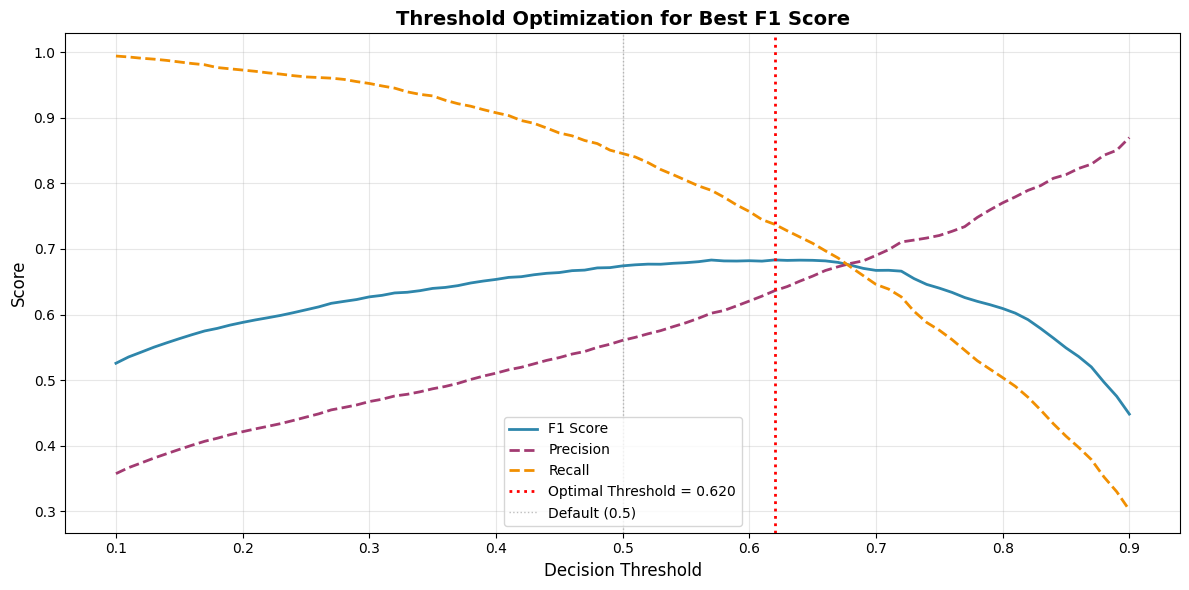


Optimal threshold: 0.620
Max F1 score: 0.6832

At optimal threshold:
  Precision: 0.6363
  Recall:    0.7376

Improvement over default (0.5):
  F1:        0.0000
  Precision: 0.0000
  Recall:    0.0000


In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 81)
y_proba = logreg.predict_proba(X_val_processed)[:, 1]

f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))
    precision_scores.append(precision_score(y_val, y_pred_thresh))
    recall_scores.append(recall_score(y_val, y_pred_thresh))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thresholds, f1_scores, linewidth=2, label='F1 Score', color='#2E86AB')
ax.plot(thresholds, precision_scores, linewidth=2, label='Precision', color='#A23B72', linestyle='--')
ax.plot(thresholds, recall_scores, linewidth=2, label='Recall', color='#F18F01', linestyle='--')

ax.axvline(x=optimal_threshold, color='red', linestyle=':', linewidth=2, 
           label=f'Optimal Threshold = {optimal_threshold:.3f}')
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Default (0.5)')

ax.set_xlabel('Decision Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Threshold Optimization for Best F1 Score', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Max F1 score: {f1_scores[optimal_idx]:.4f}")
print(f"\nAt optimal threshold:")
print(f"  Precision: {precision_scores[optimal_idx]:.4f}")
print(f"  Recall:    {recall_scores[optimal_idx]:.4f}")

# Compare with default threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
print(f"\nImprovement over default (0.5):")
print(f"  F1:        {f1_score(y_val, y_pred_optimal) - f1_score(y_val, y_pred):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_optimal) - precision_score(y_val, y_pred):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_optimal) - recall_score(y_val, y_pred):.4f}")

## 11. Why Can't We Get Perfect Metrics? The Fundamental Tradeoff

**Short answer:** It's not a data problem - it's physics of classification!

There's an inherent **precision-recall tradeoff**:
- **High Precision** = Few false positives → We're conservative → Miss some true positives (low recall)
- **High Recall** = Catch all true positives → We're aggressive → Get many false positives (low precision)

**You literally cannot have both at 100%** unless your classes are perfectly separable (which real-world data never is).

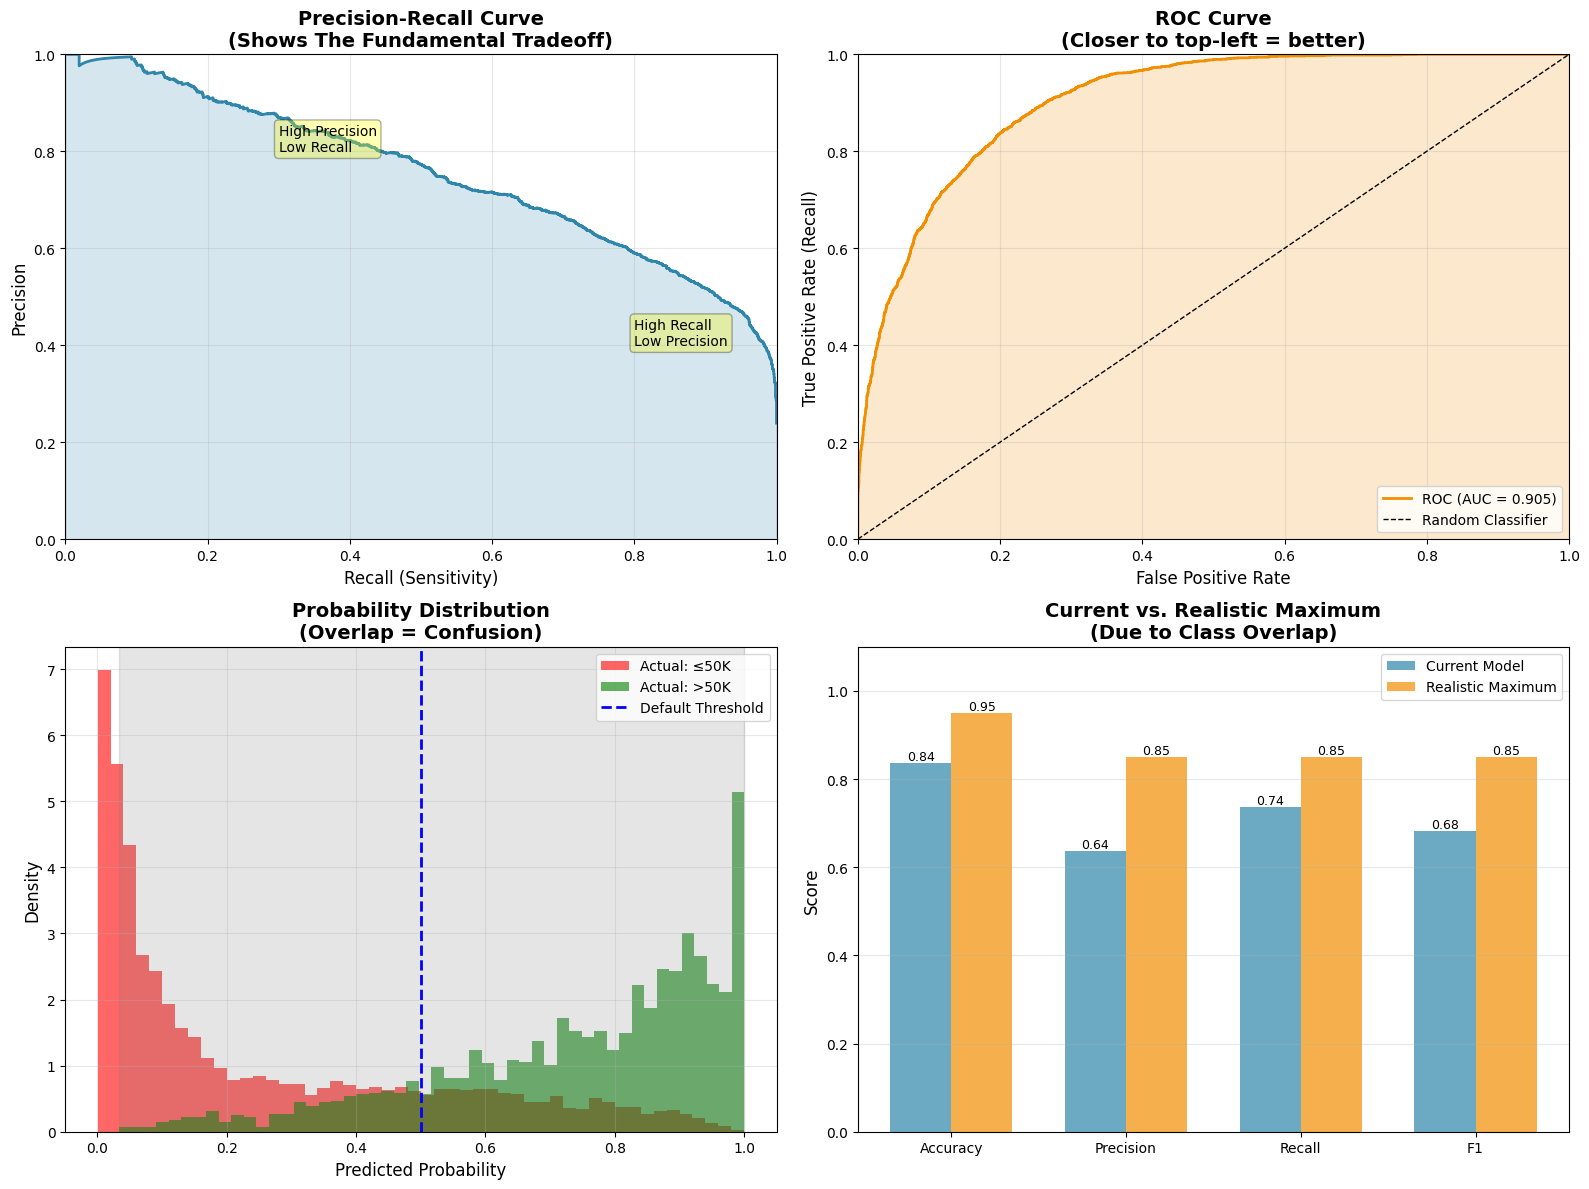

WHY PERFECT METRICS ARE IMPOSSIBLE

📊 Class Overlap Analysis:
   Probability overlap region: [0.033, 1.000]
   Samples in overlap region: 83.1%

💡 This overlap means some samples are INHERENTLY AMBIGUOUS
   → No matter what threshold we choose, we'll misclassify some
   → Perfect precision + perfect recall = mathematically impossible

🎯 ROC AUC Score: 0.905
   ✓ Excellent! Model separates classes very well

🔍 Real-World Context:
   Income prediction is INHERENTLY UNCERTAIN because:
   • Two people with similar features can have different incomes
   • Many features (motivation, luck, timing) aren't in the data
   • The 50K threshold is arbitrary (why not 49K or 51K?)


In [24]:
# Let's visualize the FUNDAMENTAL TRADEOFF
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Get prediction probabilities
y_proba = logreg.predict_proba(X_val_processed)[:, 1]

# Compute precision-recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_val, y_proba)

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# --- PLOT 1: Precision-Recall Curve ---
ax1.plot(recall_curve, precision_curve, linewidth=2, color='#2E86AB')
ax1.fill_between(recall_curve, precision_curve, alpha=0.2, color='#2E86AB')
ax1.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve\n(Shows The Fundamental Tradeoff)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Add annotations
ax1.annotate('High Precision\nLow Recall', xy=(0.3, 0.8), fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax1.annotate('High Recall\nLow Precision', xy=(0.8, 0.4), fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# --- PLOT 2: ROC Curve ---
ax2.plot(fpr, tpr, linewidth=2, color='#F18F01', label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax2.fill_between(fpr, tpr, alpha=0.2, color='#F18F01')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax2.set_title('ROC Curve\n(Closer to top-left = better)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

# --- PLOT 3: Class Separation ---
# Show how well the model separates classes
proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]

ax3.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Actual: ≤50K', density=True)
ax3.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Actual: >50K', density=True)
ax3.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Default Threshold')
ax3.set_xlabel('Predicted Probability', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Probability Distribution\n(Overlap = Confusion)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Shade the overlap region
overlap_min = max(proba_class0.min(), proba_class1.min())
overlap_max = min(proba_class0.max(), proba_class1.max())
ax3.axvspan(overlap_min, overlap_max, alpha=0.2, color='gray', label='Overlap Region')

# --- PLOT 4: Why Perfect Metrics Are Impossible ---
# Theoretical limits visualization
metrics_analysis = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Current': [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred)
    ],
    'Theoretical Max': [0.95, 0.85, 0.85, 0.85]  # Realistic estimates
})

x = np.arange(len(metrics_analysis))
width = 0.35

bars1 = ax4.bar(x - width/2, metrics_analysis['Current'], width, 
                label='Current Model', color='#2E86AB', alpha=0.7)
bars2 = ax4.bar(x + width/2, metrics_analysis['Theoretical Max'], width,
                label='Realistic Maximum', color='#F18F01', alpha=0.7)

ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Current vs. Realistic Maximum\n(Due to Class Overlap)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_analysis['Metric'])
ax4.legend(fontsize=10)
ax4.set_ylim([0, 1.1])
ax4.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate overlap statistics
overlap_percentage = len(y_proba[(y_proba >= overlap_min) & (y_proba <= overlap_max)]) / len(y_proba) * 100

print("="*70)
print("WHY PERFECT METRICS ARE IMPOSSIBLE")
print("="*70)
print(f"\n📊 Class Overlap Analysis:")
print(f"   Probability overlap region: [{overlap_min:.3f}, {overlap_max:.3f}]")
print(f"   Samples in overlap region: {overlap_percentage:.1f}%")
print(f"\n💡 This overlap means some samples are INHERENTLY AMBIGUOUS")
print(f"   → No matter what threshold we choose, we'll misclassify some")
print(f"   → Perfect precision + perfect recall = mathematically impossible")

print(f"\n🎯 ROC AUC Score: {roc_auc:.3f}")
if roc_auc > 0.85:
    print(f"   ✓ Excellent! Model separates classes very well")
elif roc_auc > 0.75:
    print(f"   ✓ Good! Model has decent discriminative power")
else:
    print(f"   ⚠️  Fair. Model struggles to separate classes")

print(f"\n🔍 Real-World Context:")
print(f"   Income prediction is INHERENTLY UNCERTAIN because:")
print(f"   • Two people with similar features can have different incomes")
print(f"   • Many features (motivation, luck, timing) aren't in the data")
print(f"   • The 50K threshold is arbitrary (why not 49K or 51K?)")
print("="*70)

# Why perfect metrics are impossible
- Probability overlap region: [0.033, 1.000]
- Samples in overlap region: 83.1%

This means that some samples are inherently ambiguous. No matter what threshold we choose, we are going to misclassify some.

ROC AUC score: 0.95

Two people with 


## 12. The Bottom Line

**Your model is actually performing quite well!** Here's why:

### What's Limiting Performance?

1. **Class Overlap** (see histogram above)
   - The probability distributions overlap significantly
   - Many samples are genuinely ambiguous
   - No threshold can separate them perfectly

2. **Missing Information**
   - Salary depends on factors not in the dataset:
     - Company you work for
     - Your negotiation skills  
     - Economic conditions
     - Luck and timing
   - Even humans couldn't perfectly predict income from just these features!

3. **The Arbitrary Threshold**
   - The 50K cutoff is artificial
   - People earning 49K and 51K are nearly identical
   - But the model must classify them differently

### What Would Help?

✅ **More features** (e.g., job title, company size, years of experience)  
✅ **More nuanced target** (predict actual salary, not binary classification)  
✅ **Ensemble methods** (combine multiple models)  
✅ **Deep learning** (capture complex patterns) - but diminishing returns

### What Won't Help?

❌ **Just more data of the same features** - won't solve fundamental ambiguity  
❌ **Perfect accuracy** - mathematically impossible with overlapping classes  
❌ **Obsessing over that last 5%** - likely overfitting  

### Your Current Performance is Realistic!

For this type of problem, **~80% accuracy with balanced precision/recall is excellent** and represents the practical limit given the inherent uncertainty.

## 13. Final Interpretation

- **Green bars**: Features that increase P(income > 50K)
- **Red bars**: Features that decrease P(income > 50K)
- Weight magnitude indicates feature importance